<a href="https://colab.research.google.com/github/vaibhavi111220/Aarki/blob/main/Aarki_Assignment_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Loads data from Lead_data.csv
# Cleans and derives flags
# Aggregates weekly quality rates and fits a logit trend
# Computes segment-level quality summaries and chi-square tests
# Simulates filtering and "select top groups" strategies to reach a quality target

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [3]:
# 1) Load raw data
df = pd.read_csv("Lead_data.csv", low_memory=False)
print("Loaded rows:", len(df))
display(df.head(8))

Loaded rows: 8819


,LeadCreated,FirstName,Email,VendorLeadID,CallStatus,WidgetName,PublisherZoneName,PublisherCampaignName,AddressScore,PhoneScore,...,Partner,ReferralDomain,MarketingCampaign,AdGroup,Keyword,SearchQuery,ReferralURL,ReferralURL Parameters,LandingPageURL,Landing Page URL Parameters
0,7/1/09,Dorinda,kanani@sandwichisles.net,FDF81FDA-A649-437B-B99C-FDDE74F7971B,NaN,w-302252-DebtReduction1-1DC-CreditSolutions,TopLeft-302252,DebtReductionInc,NaN,5.0,...,google,www.google.com,Debt Holding Tank,Holding Tank - Debt,Debt specialists,debt specialists,http://www.google.com/search,sourceid=navclient&aq=1&oq=debt sp&ie=UTF-8&rl...,http://www.debtreductioninc.com/index8.html,utm_source=google&utm_medium=CPC&utm_content=H...
1,4/13/09,Presetta,clerk2@ustconline.net,4190ACB7-5026-416C-B987-ED8AD427D5E6,NaN,w-300250-DebtReduction1-1DC-Head2,TopLeft-302252,DebtReductionInc,NaN,NaN,...,AdKnowledge,NaN,Financial Services,Consolidate,NaN,NaN,NaN,NaN,http://www.debtreductioninc.com/index8.html,utm_source=AdKnowledge&utm_medium=CPC&utm_cont...
2,4/21/09,Gina,wagoner_gina@yahoo.com,hFg80jf_R0CRN55hdhWILw,Unable to contact - Bad Contact Information,w-300250-DebtReduction1-1DC-Head2,TopLeft-302252,DebtReductionInc,NaN,NaN,...,AdKnowledge,us.mc582.mail.yahoo.com,Financial Services,Consolidate,NaN,NaN,http://us.mc582.mail.yahoo.com/mc/showMessage,&fid=Inbox&sort=date&order=down&startMid=0&.ra...,http://www.debtreductioninc.com/index8.html,utm_source=AdKnowledge&utm_medium=CPC&utm_cont...
3,8/3/09,Kari,usa4ley@yahoo.com,jB01QgYZxkWArI9jWxuufw,Contacted - Doesn't Qualify,w-302252-DebtReduction1-1DC-white,TopLeft-302252,DebtReductionInc,5.0,3.0,...,Google,norwich.kijiji.com,DebtReductionInc,Lower Payments,NaN,NaN,http://norwich.kijiji.com/c-Cars-vehicles-Cars...,NaN,http://www.debtreductioninc.com/index12.html,utm_source=Google&utm_medium=cpc&utm_campaign=...
4,4/13/09,Stephanie,sr1lambert@embarqmail.com,D5B32074-458E-40EC-B185-1FEF20AC626D,NaN,w-300250-DebtReduction1-1DC-BlueMeter,TopLeft-302252,DebtReductionInc,NaN,NaN,...,Google,NaN,DebtReductionInc,Debt Reduction,NaN,NaN,NaN,NaN,http://www.debtreductioninc.com/index8.html,utm_source=Google&utm_medium=cpc&utm_campaign=...
5,7/29/09,diana,diana.powers@tirecenters.com,94AB0C2C-0DEA-4B5D-96FA-94AE6C470CA0,NaN,w-302252-DebtReduction1-1DC-white,TopLeft-302252,DebtReductionInc,5.0,3.0,...,Google,googleads.g.doubleclick.net,DebtReductionInc,Credit Card Debt - high volume,NaN,NaN,http://googleads.g.doubleclick.net/pagead/ads,client=ca-pub-9336631000664321&dt=124889666347...,http://www.debtreductioninc.com/index8.html,utm_source=Google&utm_medium=cpc&utm_campaign=...
6,7/6/09,kyla,kmcmillion@live.com,26583F6E-49B5-47B8-96E1-A321CAF09B7A,NaN,w-302252-DebtReduction1-1DC-white,TopLeft-302252,DebtReductionInc,NaN,4.0,...,Google,googleads.g.doubleclick.net,DebtReductionInc,Student Debt,NaN,NaN,http://googleads.g.doubleclick.net/pagead/ads,client=ca-pub-4461215404735941&dt=124689889799...,http://www.debtreductioninc.com/index8.html,utm_source=Google&utm_medium=cpc&utm_campaign=...
7,4/22/09,John,johndoe333@yahoo.com,hxFrkNSCjU6rE2u-7yH-KQ,Unable to contact - Bad Contact Information,w-300250-DebtReduction1-2DC-BlueMeter,TopLeft-302252,DebtReductionInc,NaN,NaN,...,google,www.google.com,Credit,Debt Credit Services,Credit services,credit services,http://www.google.com/search,q=credit services&rls=com.microsoft:*&ie=UTF-8...,http://www.debtreductioninc.com/index8.html,utm_source=google&utm_medium=CPC&utm_content=D...


In [4]:
# 2) Clean & types
df.columns = [c.strip() for c in df.columns]

In [5]:
# Parse dates
for c in ['LeadCreated', 'WeekStart']:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors='coerce')


In [6]:
# Normalize CallStatus
df['CallStatus'] = df['CallStatus'].astype(str).str.strip()


In [7]:
# Derive IsGoodLead and IsClosed (robust substring approach)
def is_good_from_status(s):
    s_low = str(s).strip().lower()
    if s_low == 'closed':
        return 1
    # treat EP statuses as "good" (EP Sent, EP Received, EP Confirmed)
    if 'ep sent' in s_low or 'ep received' in s_low or 'ep confirmed' in s_low or s_low.startswith('ep '):
        return 1
    return 0

def is_closed_from_status(s):
    s_low = str(s).strip().lower()
    return 1 if s_low == 'closed' else 0

if 'IsGoodLead' in df.columns:
    try:
        df['IsGoodLead'] = pd.to_numeric(df['IsGoodLead'], errors='coerce').fillna(0).astype(int)
    except Exception:
        df['IsGoodLead'] = df['IsGoodLead'].apply(lambda x: 1 if str(x).lower() in ['1','true','t','yes'] else 0)
else:
    df['IsGoodLead'] = df['CallStatus'].apply(is_good_from_status)

if 'IsClosed' in df.columns:
    try:
        df['IsClosed'] = pd.to_numeric(df['IsClosed'], errors='coerce').fillna(0).astype(int)
    except Exception:
        df['IsClosed'] = df['IsClosed'].apply(lambda x: 1 if str(x).lower() in ['1','true','t','yes'] else 0)
else:
    df['IsClosed'] = df['CallStatus'].apply(is_closed_from_status)


In [8]:
# Clean a few categorical columns if present
for col in ['WidgetName','PublisherZoneName','PublisherCampaignName','AdvertiserCampaignName','Partner','ReferralDomain','MarketingCampaign','State','DebtLevel']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().replace({'nan':np.nan})

# numeric checks for address/phone scores
for sc in ['AddressScore','PhoneScore']:
    if sc in df.columns:
        df[sc] = pd.to_numeric(df[sc], errors='coerce')

In [10]:
# create WeekStart if missing using LeadCreated (week start = Monday)
if 'WeekStart' not in df.columns or df['WeekStart'].isnull().all():
    if 'LeadCreated' in df.columns:
        # Fill NaT values with a placeholder before converting to period
        df['WeekStart'] = df['LeadCreated'].fillna(pd.to_datetime('1900-01-01')).dt.to_period('W').apply(lambda r: r.start_time)
    else:
        df['WeekStart'] = pd.to_datetime('today').normalize()

In [11]:
# ensure VendorLeadID exists
if 'VendorLeadID' not in df.columns:
    df['VendorLeadID'] = np.arange(len(df)).astype(str)


In [13]:
# small category grouping for readability
def call_quality_label(x):
    s = str(x).lower()
    if s.strip() == 'closed':
        return 'Closed'
    if 'ep' in s:
        return 'EP'
    if 'unable to contact' in s or 'invalid profile' in s or ('doesn' in s and 'qualify' in s) or 'doesnt' in s:
        return 'Bad'
    return 'Unknown'
df['CallQualityGroup'] = df['CallStatus'].apply(call_quality_label)

display(df.head(8))

,LeadCreated,FirstName,Email,VendorLeadID,CallStatus,WidgetName,PublisherZoneName,PublisherCampaignName,AddressScore,PhoneScore,...,Keyword,SearchQuery,ReferralURL,ReferralURL Parameters,LandingPageURL,Landing Page URL Parameters,IsGoodLead,IsClosed,WeekStart,CallQualityGroup
0,2009-07-01,Dorinda,kanani@sandwichisles.net,FDF81FDA-A649-437B-B99C-FDDE74F7971B,nan,w-302252-DebtReduction1-1DC-CreditSolutions,TopLeft-302252,DebtReductionInc,NaN,5.0,...,Debt specialists,debt specialists,http://www.google.com/search,sourceid=navclient&aq=1&oq=debt sp&ie=UTF-8&rl...,http://www.debtreductioninc.com/index8.html,utm_source=google&utm_medium=CPC&utm_content=H...,0,0,2009-06-29,Unknown
1,2009-04-13,Presetta,clerk2@ustconline.net,4190ACB7-5026-416C-B987-ED8AD427D5E6,nan,w-300250-DebtReduction1-1DC-Head2,TopLeft-302252,DebtReductionInc,NaN,NaN,...,NaN,NaN,NaN,NaN,http://www.debtreductioninc.com/index8.html,utm_source=AdKnowledge&utm_medium=CPC&utm_cont...,0,0,2009-04-13,Unknown
2,2009-04-21,Gina,wagoner_gina@yahoo.com,hFg80jf_R0CRN55hdhWILw,Unable to contact - Bad Contact Information,w-300250-DebtReduction1-1DC-Head2,TopLeft-302252,DebtReductionInc,NaN,NaN,...,NaN,NaN,http://us.mc582.mail.yahoo.com/mc/showMessage,&fid=Inbox&sort=date&order=down&startMid=0&.ra...,http://www.debtreductioninc.com/index8.html,utm_source=AdKnowledge&utm_medium=CPC&utm_cont...,0,0,2009-04-20,Bad
3,2009-08-03,Kari,usa4ley@yahoo.com,jB01QgYZxkWArI9jWxuufw,Contacted - Doesn't Qualify,w-302252-DebtReduction1-1DC-white,TopLeft-302252,DebtReductionInc,5.0,3.0,...,NaN,NaN,http://norwich.kijiji.com/c-Cars-vehicles-Cars...,NaN,http://www.debtreductioninc.com/index12.html,utm_source=Google&utm_medium=cpc&utm_campaign=...,0,0,2009-08-03,Bad
4,2009-04-13,Stephanie,sr1lambert@embarqmail.com,D5B32074-458E-40EC-B185-1FEF20AC626D,nan,w-300250-DebtReduction1-1DC-BlueMeter,TopLeft-302252,DebtReductionInc,NaN,NaN,...,NaN,NaN,NaN,NaN,http://www.debtreductioninc.com/index8.html,utm_source=Google&utm_medium=cpc&utm_campaign=...,0,0,2009-04-13,Unknown
5,2009-07-29,diana,diana.powers@tirecenters.com,94AB0C2C-0DEA-4B5D-96FA-94AE6C470CA0,nan,w-302252-DebtReduction1-1DC-white,TopLeft-302252,DebtReductionInc,5.0,3.0,...,NaN,NaN,http://googleads.g.doubleclick.net/pagead/ads,client=ca-pub-9336631000664321&dt=124889666347...,http://www.debtreductioninc.com/index8.html,utm_source=Google&utm_medium=cpc&utm_campaign=...,0,0,2009-07-27,Unknown
6,2009-07-06,kyla,kmcmillion@live.com,26583F6E-49B5-47B8-96E1-A321CAF09B7A,nan,w-302252-DebtReduction1-1DC-white,TopLeft-302252,DebtReductionInc,NaN,4.0,...,NaN,NaN,http://googleads.g.doubleclick.net/pagead/ads,client=ca-pub-4461215404735941&dt=124689889799...,http://www.debtreductioninc.com/index8.html,utm_source=Google&utm_medium=cpc&utm_campaign=...,0,0,2009-07-06,Unknown
7,2009-04-22,John,johndoe333@yahoo.com,hxFrkNSCjU6rE2u-7yH-KQ,Unable to contact - Bad Contact Information,w-300250-DebtReduction1-2DC-BlueMeter,TopLeft-302252,DebtReductionInc,NaN,NaN,...,Credit services,credit services,http://www.google.com/search,q=credit services&rls=com.microsoft:*&ie=UTF-8...,http://www.debtreductioninc.com/index8.html,utm_source=google&utm_medium=CPC&utm_content=D...,0,0,2009-04-20,Bad


In [14]:
# 3) Baseline metrics
total_leads = len(df)
good_leads = int(df['IsGoodLead'].sum())
closed_leads = int(df['IsClosed'].sum())
baseline_quality = good_leads / total_leads
baseline_close_rate = closed_leads / total_leads

print(f"Total leads: {total_leads:,}")
print(f"Good leads: {good_leads:,}  ({baseline_quality:.4%})")
print(f"Closed leads: {closed_leads:,} ({baseline_close_rate:.4%})")

Total leads: 8,819
Good leads: 393  (4.4563%)
Closed leads: 245 (2.7781%)


In [16]:
# save baseline
OUT_DIR = Path('.')  # Define OUT_DIR, using the current directory as an example
pd.DataFrame({
    'metric':['total_leads','good_leads','closed_leads','baseline_quality','baseline_close_rate'],
    'value':[total_leads, good_leads, closed_leads, baseline_quality, baseline_close_rate]
}).to_csv(OUT_DIR / "baseline_summary.csv", index=False)

,WeekStart,n_total,n_good,n_closed,quality_rate,close_rate,week_ordinal
0,1900-01-01,0,0,0,NaN,NaN,0
1,2009-03-30,37,6,3,0.162162,0.081081,5700
2,2009-04-06,119,18,15,0.151261,0.126050,5701
3,2009-04-13,125,21,16,0.168000,0.128000,5702
4,2009-04-20,155,25,14,0.161290,0.090323,5703


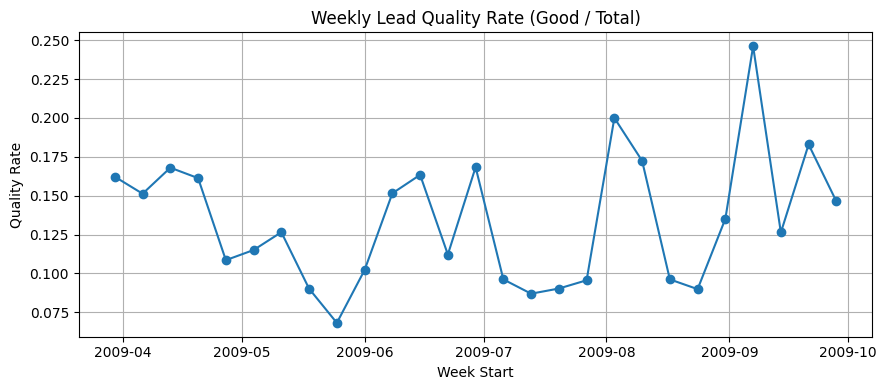

In [35]:
# 4) Weekly aggregation & plot
weekly = df.groupby('WeekStart').agg(
    n_total=('VendorLeadID','count'),
    n_good=('IsGoodLead','sum'),
    n_closed=('IsClosed','sum')
).reset_index().sort_values('WeekStart')

weekly['quality_rate'] = weekly['n_good'] / weekly['n_total']
weekly['close_rate'] = weekly['n_closed'] / weekly['n_total']
weekly['week_ordinal'] = (weekly['WeekStart'] - weekly['WeekStart'].min()).dt.days // 7

weekly.to_csv(OUT_DIR / "weekly_aggregates.csv", index=False)
display(weekly.head())

plt.figure(figsize=(9,4))
plt.plot(weekly['WeekStart'], weekly['quality_rate'], marker='o')
plt.title('Weekly Lead Quality Rate (Good / Total)')
plt.xlabel('Week Start')
plt.ylabel('Quality Rate')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig(OUT_DIR / "weekly_quality_rate.png")
plt.close()

                           Logit Regression Results                           
Dep. Variable:             IsGoodLead   No. Observations:                 8819
Model:                          Logit   Df Residuals:                     8817
Method:                           MLE   Df Model:                            1
Date:                Tue, 28 Oct 2025   Pseudo R-squ.:                  0.2732
Time:                        12:04:06   Log-Likelihood:                -1167.7
converged:                       True   LL-Null:                       -1606.7
Covariance Type:            nonrobust   LLR p-value:                6.022e-193
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -21.2231     43.225     -0.491      0.623    -105.943      63.496
week_ordinal     0.0034      0.008      0.447      0.655      -0.011       0.018

Possibly complete quasi-separation: A fract

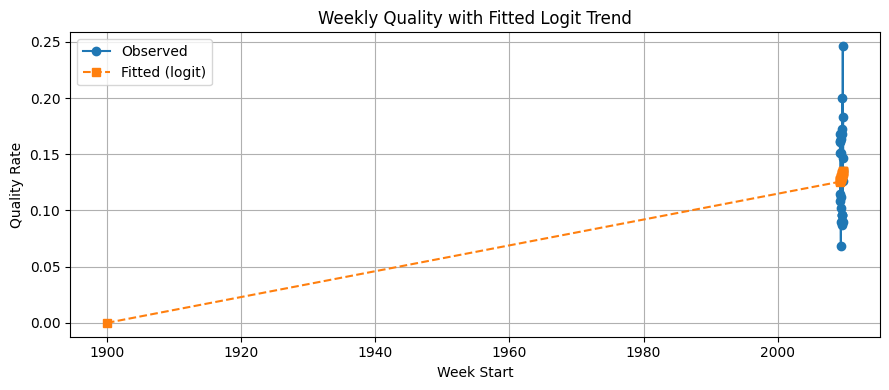

In [34]:
# 5) Trend test: row-wise logistic regression (IsGoodLead ~ week_ordinal)
df_temp = df.dropna(subset=['WeekStart']).copy()
df_temp['week_ordinal'] = (df_temp['WeekStart'] - df_temp['WeekStart'].min()).dt.days // 7

logit_mod = smf.logit("IsGoodLead ~ week_ordinal", data=df_temp).fit(disp=False)
print(logit_mod.summary())
glm_pvalue = float(logit_mod.pvalues.get('week_ordinal', np.nan))
glm_coef = float(logit_mod.params.get('week_ordinal', np.nan))
print(f"Logit trend coef: {glm_coef:.6f}, p-value: {glm_pvalue:.6f}")

# add fitted curve per week for plotting
df_temp['pred_prob'] = logit_mod.predict(df_temp)
fitted_week = df_temp.groupby('week_ordinal').agg(pred_prob_mean=('pred_prob','mean')).reset_index()
# map week_ordinal to WeekStart
week_map = weekly[['week_ordinal','WeekStart']].drop_duplicates().set_index('week_ordinal')['WeekStart']
fitted_week['WeekStart'] = fitted_week['week_ordinal'].map(week_map)

plt.figure(figsize=(9,4))
plt.plot(weekly['WeekStart'], weekly['quality_rate'], marker='o', label='Observed')
plt.plot(fitted_week['WeekStart'], fitted_week['pred_prob_mean'], marker='s', linestyle='--', label='Fitted (logit)')
plt.title('Weekly Quality with Fitted Logit Trend')
plt.xlabel('Week Start')
plt.ylabel('Quality Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig(OUT_DIR / "weekly_quality_with_fit.png")
plt.close()


In [25]:
# 6) Segment analysis (select columns present)
seg_cols = [c for c in ['WidgetName','PublisherZoneName','PublisherCampaignName','AdvertiserCampaignName','Partner','ReferralDomain','MarketingCampaign','State'] if c in df.columns]

def seg_summary(col, top_n=10, min_count=8):
    grp = df.groupby(col).agg(n_total=('VendorLeadID','count'), n_good=('IsGoodLead','sum')).reset_index()
    grp = grp[grp['n_total'] >= min_count].copy()
    grp['quality_rate'] = grp['n_good'] / grp['n_total']
    grp_sorted = grp.sort_values('quality_rate', ascending=False)
    return grp_sorted, grp_sorted.head(top_n), grp_sorted.tail(top_n)

segment_summaries = {}
for col in seg_cols:
    grp_sorted, top, bot = seg_summary(col, top_n=10, min_count=8)
    segment_summaries[col] = {'all': grp_sorted, 'top': top, 'bottom': bot}
    grp_sorted.to_csv(OUT_DIR / f"segment_summary_{col}.csv", index=False)
    top.to_csv(OUT_DIR / f"segment_top_{col}.csv", index=False)
    bot.to_csv(OUT_DIR / f"segment_bottom_{col}.csv", index=False)
    print(f"Saved segment summary for {col} (groups >=8)")


Saved segment summary for WidgetName (groups >=8)
Saved segment summary for PublisherZoneName (groups >=8)
Saved segment summary for PublisherCampaignName (groups >=8)
Saved segment summary for AdvertiserCampaignName (groups >=8)
Saved segment summary for Partner (groups >=8)
Saved segment summary for ReferralDomain (groups >=8)
Saved segment summary for MarketingCampaign (groups >=8)
Saved segment summary for State (groups >=8)


In [26]:
# 7) Chi-square tests (top categories by frequency)
chi_results = []
for col in seg_cols:
    top_cats = df[col].value_counts().head(8).index.tolist()
    ct = pd.crosstab(df[col].where(df[col].isin(top_cats)), df['IsGoodLead']).fillna(0).astype(int)
    if ct.shape[0] >= 2 and ct.shape[1] >= 2:
        chi2, p, dof, ex = stats.chi2_contingency(ct)
        chi_results.append({'variable':col, 'chi2':chi2, 'pvalue':p, 'dof':dof, 'rows':ct.shape[0]})
        print(f"Chi-square {col}: chi2={chi2:.2f}, p={p:.4f}")
    else:
        chi_results.append({'variable':col, 'chi2':np.nan, 'pvalue':np.nan, 'dof':np.nan, 'rows':ct.shape[0]})
pd.DataFrame(chi_results).sort_values('pvalue').to_csv(OUT_DIR / "chi_square_results.csv", index=False)


Chi-square WidgetName: chi2=7.92, p=0.3401
Chi-square PublisherZoneName: chi2=2.44, p=0.1186
Chi-square PublisherCampaignName: chi2=2.44, p=0.1186
Chi-square AdvertiserCampaignName: chi2=0.00, p=1.0000
Chi-square Partner: chi2=30.33, p=0.0000
Chi-square ReferralDomain: chi2=17.20, p=0.0161
Chi-square MarketingCampaign: chi2=23.16, p=0.0016
Chi-square State: chi2=8.14, p=0.3201


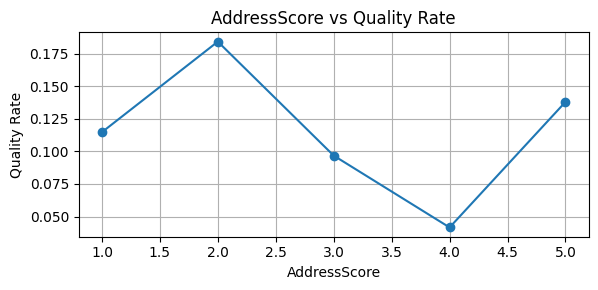

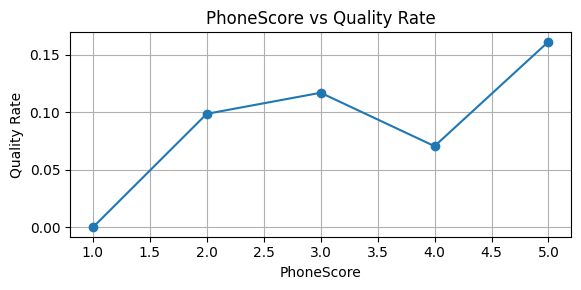

In [33]:
# 8) AddressScore/PhoneScore insights
for sc in ['AddressScore','PhoneScore']:
    if sc in df.columns:
        sc_grp = df.groupby(sc).agg(n_total=('VendorLeadID','count'), n_good=('IsGoodLead','sum')).reset_index()
        sc_grp['quality_rate'] = sc_grp['n_good'] / sc_grp['n_total']
        sc_grp.to_csv(OUT_DIR / f"{sc}_summary.csv", index=False)
        plt.figure(figsize=(6,3))
        plt.plot(sc_grp[sc], sc_grp['quality_rate'], marker='o')
        plt.title(f"{sc} vs Quality Rate")
        plt.xlabel(sc)
        plt.ylabel("Quality Rate")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        plt.savefig(OUT_DIR / f"{sc}_vs_quality.png")
        plt.close()

In [29]:
# 9) Identify groups already >= target (9.6%)
TARGET = 0.096
segments_above_target = {}
for col in seg_cols:
    grp = df.groupby(col).agg(n_total=('VendorLeadID','count'), n_good=('IsGoodLead','sum')).reset_index()
    grp['quality_rate'] = grp['n_good'] / grp['n_total']
    good_segments = grp[(grp['quality_rate'] >= TARGET) & (grp['n_total'] >= 5)].sort_values('quality_rate', ascending=False)
    if len(good_segments) > 0:
        segments_above_target[col] = good_segments
        good_segments.to_csv(OUT_DIR / f"{col}_above_{int(TARGET*10000)}.csv", index=False)
        display(f"{col} >= {TARGET:.2%}", good_segments)

'WidgetName >= 9.60%'

,WidgetName,n_total,n_good,quality_rate
11,w-302252-DebtReduction1-1DC-yellowarrow,49,12,0.244898
2,w-300250-DebtReduction1-1DC-CreditSolutions,77,18,0.233766
5,w-300250-DebtReduction1-1DC-white,6,1,0.166667
0,w-300250-DebtReduction1-1DC,348,56,0.160920
3,w-300250-DebtReduction1-1DC-Head2,89,14,0.157303
1,w-300250-DebtReduction1-1DC-BlueMeter,92,14,0.152174
6,w-300250-DebtReduction1-2DC-BlueMeter,87,12,0.137931
12,w-302252-DebtReduction1-1DC-yellowarrow-blue,232,31,0.133621
9,w-302252-DebtReduction1-1DC-CreditSolutions,1054,131,0.124288
8,w-302252-DebtReduction1-1DC,272,32,0.117647


'PublisherZoneName >= 9.60%'

,PublisherZoneName,n_total,n_good,quality_rate
0,Top Right-300x250,271,44,0.162362
1,TopLeft-302252,2750,349,0.126909


'PublisherCampaignName >= 9.60%'

,PublisherCampaignName,n_total,n_good,quality_rate
0,DebtReductionCallCenter,271,44,0.162362
1,DebtReductionInc,2750,349,0.126909


'AdvertiserCampaignName >= 9.60%'

,AdvertiserCampaignName,n_total,n_good,quality_rate
1,creditsolutions-branded-shortform,1206,157,0.130182
0,Debt Settlement1 Master,1815,236,0.130028


'Partner >= 9.60%'

,Partner,n_total,n_good,quality_rate
0,AdKnowledge,171,32,0.187135
2,Call_Center,271,44,0.162362
5,yahoo,958,136,0.141962
4,google,979,135,0.137896


'ReferralDomain >= 9.60%'

,ReferralDomain,n_total,n_good,quality_rate
103,search.alot.com,6,3,0.500000
109,search.comcast.net,7,3,0.428571
222,ww23.rr.com,7,3,0.428571
319,www.ndparking.com,5,2,0.400000
82,my.att.net,8,3,0.375000
113,search.earthlink.net,7,2,0.285714
279,www.fastbrowsersearch.com,8,2,0.250000
295,www.justclicklocal.com,12,3,0.250000
121,search.mywebsearch.com,26,6,0.230769
200,us.mg2.mail.yahoo.com,9,2,0.222222


'MarketingCampaign >= 9.60%'

,MarketingCampaign,n_total,n_good,quality_rate
9,Debt Volume_MI,5,2,0.400000
10,Debt Volume_TX,7,2,0.285714
17,Financial Services,171,32,0.187135
5,Debt Holding Tank,338,61,0.180473
7,Debt Volume,143,23,0.160839
0,Credit,100,14,0.140000
18,state,97,12,0.123711
3,Debt Consolidation,34,4,0.117647
11,DebtReductionInc,1473,166,0.112695


'State >= 9.60%'

,State,n_total,n_good,quality_rate
24,OK,50,13,0.260000
9,HI,32,7,0.218750
20,NE,22,4,0.181818
6,CT,23,4,0.173913
14,MA,70,12,0.171429
1,AL,96,16,0.166667
4,CA,463,73,0.157667
31,WV,52,8,0.153846
3,AZ,94,14,0.148936
25,OR,54,8,0.148148


In [31]:
# 10) Simulation: cumulative selection of top groups to reach target (example: WidgetName & Partner)
def simulate_selection_for_target(grp_df, target_rate):
    df_sorted = grp_df.sort_values('quality_rate', ascending=False).reset_index(drop=True).copy()
    df_sorted['cum_leads'] = df_sorted['n_total'].cumsum()
    df_sorted['cum_good'] = df_sorted['n_good'].cumsum()
    df_sorted['cum_rate'] = df_sorted['cum_good'] / df_sorted['cum_leads']
    reached = df_sorted[df_sorted['cum_rate'] >= target_rate]
    if len(reached) == 0:
        return None, df_sorted
    idx = reached.index[0]
    used = df_sorted.loc[:idx].copy()
    return used, df_sorted

for col in ['WidgetName','Partner']:
    if col in seg_cols:
        grp = df.groupby(col).agg(n_total=('VendorLeadID','count'), n_good=('IsGoodLead','sum')).reset_index()
        grp['quality_rate'] = grp['n_good'] / grp['n_total']
        used, full = simulate_selection_for_target(grp, TARGET)
        if used is not None:
            used.to_csv(OUT_DIR / f"selection_for_target_{col}.csv", index=False)
            display(f"Selection achieving target - {col}", used)
        else:
            full.to_csv(OUT_DIR / f"{col}_all_sorted.csv", index=False)

'Selection achieving target - WidgetName'

,WidgetName,n_total,n_good,quality_rate,cum_leads,cum_good,cum_rate
0,w-302252-DebtReduction1-1DC-yellowarrow,49,12,0.244898,49,12,0.244898


'Selection achieving target - Partner'

,Partner,n_total,n_good,quality_rate,cum_leads,cum_good,cum_rate
0,Advertise.com,3,1,0.333333,3,1,0.333333


In [32]:
# 11) Practical filtering simulation function (e.g. AddressScore >=4 & PhoneScore >=4)
def simulate_filtering(address_threshold=None, phone_threshold=None, widgets_include=None, partners_include=None):
    df_sim = df.copy()
    if address_threshold is not None and 'AddressScore' in df_sim.columns:
        df_sim = df_sim[df_sim['AddressScore'] >= address_threshold]
    if phone_threshold is not None and 'PhoneScore' in df_sim.columns:
        df_sim = df_sim[df_sim['PhoneScore'] >= phone_threshold]
    if widgets_include is not None and 'WidgetName' in df_sim.columns:
        df_sim = df_sim[df_sim['WidgetName'].isin(widgets_include)]
    if partners_include is not None and 'Partner' in df_sim.columns:
        df_sim = df_sim[df_sim['Partner'].isin(partners_include)]
    total = len(df_sim)
    good = int(df_sim['IsGoodLead'].sum())
    rate = good/total if total>0 else np.nan
    return {'n_total':total, 'n_good':good, 'rate':rate}

if 'AddressScore' in df.columns and 'PhoneScore' in df.columns:
    sim = simulate_filtering(address_threshold=4, phone_threshold=4)
    print("Filtering AddressScore>=4 AND PhoneScore>=4 ->", sim)
    df[(df['AddressScore']>=4) & (df['PhoneScore']>=4)].to_csv(OUT_DIR / "leads_filtered_address4_phone4.csv", index=False)



Filtering AddressScore>=4 AND PhoneScore>=4 -> {'n_total': 562, 'n_good': 82, 'rate': 0.14590747330960854}


In [36]:
# 12) Save cleaned dataset + top segments overview
df.to_csv(OUT_DIR / "lead_data_cleaned.csv", index=False)
top_segments = []
for col in seg_cols:
    top = segment_summaries[col]['top'].copy()
    top['dimension'] = col
    top = top.rename(columns={col: 'group'}) if col in top.columns else top
    if 'group' not in top.columns:
        top = top.rename(columns={top.columns[0]:'group'})
    top = top[['group','n_total','n_good','quality_rate','dimension']]
    top_segments.append(top)
if top_segments:
    pd.concat(top_segments, ignore_index=True).to_csv(OUT_DIR / "top_segments_overall.csv", index=False)

print("Outputs saved to:", OUT_DIR)
for f in sorted(OUT_DIR.iterdir()):
    print("-", f.name)


Outputs saved to: .
- .config
- AddressScore_summary.csv
- AddressScore_vs_quality.png
- AdvertiserCampaignName_above_960.csv
- Lead_data.csv
- MarketingCampaign_above_960.csv
- Partner_above_960.csv
- PhoneScore_summary.csv
- PhoneScore_vs_quality.png
- PublisherCampaignName_above_960.csv
- PublisherZoneName_above_960.csv
- ReferralDomain_above_960.csv
- State_above_960.csv
- WidgetName_above_960.csv
- baseline_summary.csv
- chi_square_results.csv
- lead_data_cleaned.csv
- leads_filtered_address4_phone4.csv
- sample_data
- segment_bottom_AdvertiserCampaignName.csv
- segment_bottom_MarketingCampaign.csv
- segment_bottom_Partner.csv
- segment_bottom_PublisherCampaignName.csv
- segment_bottom_PublisherZoneName.csv
- segment_bottom_ReferralDomain.csv
- segment_bottom_State.csv
- segment_bottom_WidgetName.csv
- segment_summary_AdvertiserCampaignName.csv
- segment_summary_MarketingCampaign.csv
- segment_summary_Partner.csv
- segment_summary_PublisherCampaignName.csv
- segment_summary_Publis